In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

directory_path = '/content/drive/MyDrive/pickled_data'

# List the files in the directory
files = os.listdir(directory_path)

# Print the list of files in the directory
print(files)

['image_dev.pkl', 'image_test.pkl', 'image_train.pkl', 'mask_dev.pkl', 'mask_test.pkl', 'mask_train.pkl', 'sunnybrook_A-unet_model-05.hdf5', 'sunnybrook_A-unet_model-10.hdf5', 'sunnybrook_A-unet_model-15.hdf5', 'sunnybrook_A-unet_model-20.hdf5', 'sunnybrook_A-unet_model-25.hdf5', 'sunnybrook_A-unet_model-30.hdf5']


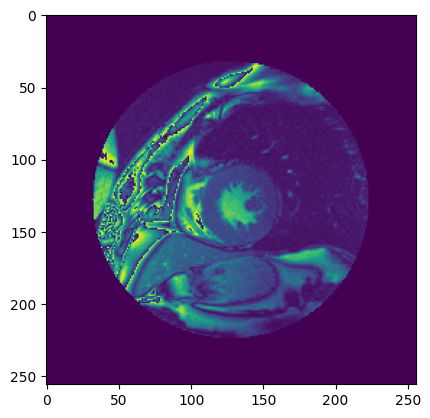

In [ ]:
import pickle
import matplotlib.pyplot as plt

# Specify the path to the pickle file you want to open
pickle_file_path = '/content/drive/MyDrive/pickled_data/image_train.pkl'

# Load the data from the pickle file
with open(pickle_file_path, 'rb') as file:
    data = pickle.load(file)

# Assuming data is a list of images (numpy arrays)
# Display the first image in the list
plt.imshow(data[14])
plt.show()

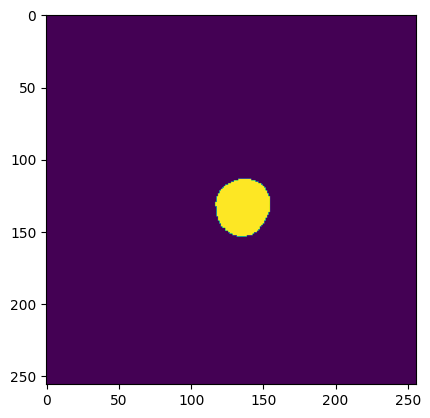

In [ ]:
import pickle
import matplotlib.pyplot as plt

# Specify the path to the pickle file you want to open
pickle_file_path = '/content/drive/MyDrive/pickled_data/mask_train.pkl'

# Load the data from the pickle file
with open(pickle_file_path, 'rb') as file:
    data = pickle.load(file)

# Assuming data is a list of images (numpy arrays)
# Display the first image in the list
plt.imshow(data[14])
plt.show()

In [ ]:
pip install tensorflow tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.3/612.3 kB 4.1 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
from keras import backend as K
import cv2
from keras.preprocessing.image import ImageDataGenerator
import pickle
from keras.callbacks import ModelCheckpoint
from skimage import img_as_ubyte
from keras.models import *
from keras.layers import *
from keras.optimizers import *
import tensorflow as tf
from tensorflow_addons.layers import MultiHeadAttention

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
seed = 1234
np.random.seed(seed)

startDir = 'drive/My Drive/pickled_data/'
weights_dir = startDir

In [ ]:
def show_images(images, dpi = 72, cols = 1, titles = None):
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    plt.rcParams['figure.dpi'] = dpi
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()
    plt.rcParams['figure.dpi'] = 72

In [ ]:
def plot_rows_cols(imgs,ttls=[]):
  ofs = plt.rcParams['figure.figsize']
  fig=plt.figure(figsize=(16, 16))
  columns = 5
  rows = int(len(imgs)/columns)
  ax = []
  for i in range(1, columns*rows +1):
      img = imgs[i-1]
      ax.append(fig.add_subplot(rows, columns, i))
      if ttls != [] and len(imgs) == len(ttls):
        ax[-1].set_title(ttls[i-1])
      plt.imshow(img)
  plt.subplots_adjust(bottom=0.3,hspace=0)
  plt.show()
  plt.rcParams['figure.figsize'] = ofs

In [ ]:
def addmask_border(img, msk, clr = (255,255,0), thickness = 1):
    image = img.copy()
    if np.ndim(image) == 2:
      #image = image.astype('uint8')
      image = img_as_ubyte(image)
      image = cv2.cvtColor(image,cv2.COLOR_GRAY2BGR)
    bmsk = msk.copy().astype('uint8')
    contours, _ = cv2.findContours(bmsk, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) > 0:
      lenctrs = [len(ctr) for ctr in contours]
      maxctridx = np.argmax(lenctrs)
      pts = np.array([pt[0] for pt in contours[maxctridx]])
      cv2.polylines(image,[pts],True,clr, thickness = thickness)
    return(image)

In [ ]:
# draw images with ndim 3 with shape (x,x,1)
def draw_images(imgs, titles = None, dpi = 72):
  simgs = []
  for i in range(len(imgs)):
    simg = np.squeeze(imgs[i])
    simgs.append(simg)
  show_images(simgs, titles=titles, dpi = dpi)

In [ ]:
def draw_overlap_border(image, mask, dpi = 72, thickness = 1, clr = (0,255,0), title = ['border in green'] ):
  img1 = np.squeeze(image)
  img2 = np.squeeze(mask)
  bimg1 = addmask_border(img1, img2, clr = clr, thickness = thickness)
  show_images([bimg1],titles=title, dpi = dpi)


In [ ]:
def find_overlap_border(image, mask, thickness = 1, clr = (255,0,0)):
  img1 = np.squeeze(image)
  img2 = np.squeeze(mask)
  bimg1 = addmask_border(img1, img2, clr = clr, thickness = thickness)
  return(bimg1)

In [ ]:
def find_border(chkidx, imgarr, mskarr, clr=(255,255,0), thickness = 1):
  img1 = imgarr[chkidx]
  img1 = np.squeeze(img1)
  img2 = mskarr[chkidx]
  img2 = np.squeeze(img2)
  img2 = np.array(img2, dtype=np.uint8)
  img3 = addmask_border(img1,img2,clr=clr,thickness = thickness)
  #img3 = cv2.cvtColor(img3,cv2.COLOR_BGR2GRAY)
  return(img3)

In [ ]:
def get_imagestodraw(idx, imgarr, mskarr, predarr):
    idx = idx
    img_border = find_border(idx, imgarr, mskarr, thickness = 2, clr = (255,255,0))
    img_border = find_overlap_border(img_border, predarr[idx], thickness = 2, clr = (255,0,0))
    #print(img_border.shape)

    msk_t = mskarr[idx]
    msk_t = np.squeeze(msk_t)
    msk_t = np.array(msk_t, dtype=np.uint8)
    msk_t[msk_t==1] = 255
    msk_t = cv2.cvtColor(msk_t,cv2.COLOR_GRAY2BGR)
    msk_t[np.where((msk_t==[255,255,255]).all(axis=2))] = [255,255,0]

    msk_p = predarr[idx]
    msk_p = np.squeeze(msk_p)
    msk_p = np.where(msk_p > 0.6,255.0,0.0)
    msk_p = np.array(msk_p,dtype=np.uint8)
    msk_p = cv2.cvtColor(msk_p,cv2.COLOR_GRAY2BGR)
    msk_p[np.where((msk_p==[255,255,255]).all(axis=2))] = [255,0,0]

    img_t = imgarr[idx]
    img_t = np.squeeze(img_t)
    img_t = img_as_ubyte(img_t)
    img_t = cv2.cvtColor(img_t,cv2.COLOR_GRAY2BGR)
    img_tm = img_t.copy()
    img_tm[(msk_t==[255,255,0]).all(axis=2)] = [255,255,0]
    img_tp = img_t.copy()
    img_tp[(msk_p==[255,0,0]).all(axis=2)] = [255,0,0]

    overlay = img_tm
    alpha = 0.5
    output = img_border   # img_t
    output_img = cv2.addWeighted(overlay, alpha, output, 1 - alpha, 0)
    alpha = 0.5
    overlay = img_tp   # msk_p
    output_img = cv2.addWeighted(overlay, alpha, output_img, 1 - alpha, 0)
    return (img_t, img_tm, img_tp, img_border, output_img)

In [ ]:
def plot_training(results, loss1 = 'loss', mon1 = 'val_loss', mon2 = ''):
  plt.figure(figsize=(8, 8))
  plt.title("Learning curve")
  plt.plot(results.history[loss1], label=loss1)
  if mon1 in results.history.keys():
    plt.plot(results.history[mon1], label=mon1)
  if mon2 != '':
    if mon2 in results.history.keys():
      plt.plot(results.history[mon2], label=mon2)
  plt.xlabel("Epochs")
  plt.ylabel("loss/mon")
  plt.legend();

In [ ]:
def store_output_images(imgcnt = 1, dictofimgs={'orig':None,'amsk':None,'pmsk':None,'bimg':None,'oimg':None}):
  thiscnt = 1
  for k in dictofimgs.keys():
    if dictofimgs[k] is None:
      pass
    else:
      fn = startDir + k + '_' + str(imgcnt) + '.png'
      img = dictofimgs[k]
      img  = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
      cv2.imwrite(fn,img)
      thiscnt += 1


In [ ]:
# load arrays from pickle files
def load_pickled_data():

  image_train_pickle_file = startDir + 'image_train.pkl'
  image_dev_pickle_file = startDir + 'image_dev.pkl'
  image_test_pickle_file = startDir + 'image_test.pkl'
  mask_train_pickle_file = startDir + 'mask_train.pkl'
  mask_dev_pickle_file = startDir + 'mask_dev.pkl'
  mask_test_pickle_file = startDir + 'mask_test.pkl'

  with open(image_train_pickle_file, 'rb') as f:
    image_train = pickle.load(f)
  with open(image_dev_pickle_file, 'rb') as f:
    image_dev = pickle.load(f)
  with open(image_test_pickle_file, 'rb') as f:
    image_test = pickle.load(f)

  with open(mask_train_pickle_file, 'rb') as f:
    mask_train = pickle.load(f)
  with open(mask_dev_pickle_file, 'rb') as f:
    mask_dev = pickle.load(f)
  with open(mask_test_pickle_file, 'rb') as f:
    mask_test = pickle.load(f)

  return image_train, image_dev, image_test, mask_train, mask_dev,mask_test


In [ ]:
# Model loss and monitor functions

def dice_coef(y_true, y_pred, smooth=0.0):
    '''Average dice coefficient per batch.'''

    axes = (1,2,3)
    intersection = K.sum(y_true * y_pred, axis=axes)
    summation = K.sum(y_true, axis=axes) + K.sum(y_pred, axis=axes)

    return K.mean((2.0 * intersection + smooth) / (summation + smooth), axis=0)

def jaccard_coef(y_true, y_pred, smooth=0.0):
    '''Average jaccard coefficient per batch.'''

    axes = (1,2,3)
    intersection = K.sum(y_true * y_pred, axis=axes)
    union = K.sum(y_true, axis=axes) + K.sum(y_pred, axis=axes) - intersection
    return K.mean( (intersection + smooth) / (union + smooth), axis=0)

def dice_loss(smooth):
  def dice(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred, smooth=smooth)
  return dice

def dice_mon(smooth):
  def dicemon(y_true, y_pred):
    return dice_coef(y_true, y_pred, smooth=smooth)
  return dicemon

def jaccard_mon(smooth):
  def jaccardmon(y_true, y_pred):
    return jaccard_coef(y_true, y_pred, smooth=smooth)
  return jaccardmon

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, UpSampling2D, GlobalAveragePooling2D, Reshape, Dense, Multiply, Add
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import BinaryCrossentropy
import tensorflow.keras.backend as K

# Define Convolutional Block
def conv_block(layer_before, features, block_no=0, activation='relu', padding='same', kernel_initializer='glorot_uniform', pool_bool=True):
    if pool_bool:
        block = '_convblock_' + str(block_no)
    else:
        block = '_middleblock'
    conv = Conv2D(features, 3, activation=activation, padding=padding, kernel_initializer=kernel_initializer, name='conv1' + block)(layer_before)
    conv = BatchNormalization()(conv)
    conv = Conv2D(features, 3, activation=activation, padding=padding, kernel_initializer=kernel_initializer, name='conv2' + block)(conv)
    conv = BatchNormalization()(conv)
    if pool_bool:
        conv = MaxPooling2D(pool_size=(2, 2), name='pool' + block)(conv)
    return conv


In [ ]:
# Define Deconvolution Block
def deconv_block(layer_before, features, block_no=0, activation='relu', padding='same', kernel_initializer='glorot_uniform'):
    if block_no == 0:
        conv = Conv2D(2, 3, activation=activation, padding=padding, kernel_initializer=kernel_initializer)(layer_before)
        return conv
    block = '_deconvblock_' + str(block_no)
    up = UpSampling2D(size=(2, 2), name='up' + block)(layer_before)
    conv = Conv2D(features, 2, activation=activation, padding=padding, kernel_initializer=kernel_initializer, name='conv1' + block)(up)
    conv = BatchNormalization()(conv)
    conv = Conv2D(features, 3, activation=activation, padding=padding, kernel_initializer=kernel_initializer, name='conv2' + block)(conv)
    conv = BatchNormalization()(conv)
    return conv

In [ ]:
# Define the Attention Mechanism
def SpatialAttention(input_feature, ratio=8):
    avg_pool = GlobalAveragePooling2D()(input_feature)
    avg_pool = Reshape((1, 1, avg_pool.shape[-1]))(avg_pool)
    avg_pool = Dense(input_feature.shape[-1] // ratio, activation='relu')(avg_pool)
    avg_pool = Dense(input_feature.shape[-1], activation='sigmoid')(avg_pool)

    multiplied = Multiply()([input_feature, avg_pool])
    added = Add()([input_feature, multiplied])

    return added

In [ ]:
# Modify encoder function to add Spatial Attention
def encoder(input_layer, starting_features=64, depth=4):
    conv = input_layer
    features = starting_features
    for i in range(depth):
        conv = conv_block(conv, features, block_no=i+1)
        features *= 2
        conv = SpatialAttention(conv)
    return conv, features

# Modify decoder function to add Spatial Attention
def decoder(input_conv, features=1024, height=4):
    conv = input_conv
    features = int(features / 2)
    for i in range(height):
        conv = SpatialAttention(conv)
        conv = deconv_block(conv, features, block_no=i+1)
        features = int(features / 2)
    conv = deconv_block(conv, features, block_no=0)
    return conv

In [ ]:
# Build the Attention U-Net model
def build_attention_unet(input_size=(256, 256, 1), depth=4):
    inputs = Input(input_size)
    conv, features = encoder(inputs, depth=depth)
    middle_conv = conv_block(conv, features, pool_bool=False)
    conv = decoder(middle_conv, features=features, height=depth)
    out = Conv2D(1, 1, activation='sigmoid')(conv)

    model = Model(inputs=inputs, outputs=out)

    return model


In [ ]:
# Compile the Attention U-Net model
def compile_attention_model(depth=4):
    model = build_attention_unet(depth=depth)
    smooth = K.epsilon()
    model_dice = dice_loss(smooth=smooth)    #smooth=K.epsilon()
    dicemon = dice_mon(smooth)
    jaccardmon = jaccard_mon(smooth)
    sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)
    model.compile(optimizer = sgd, loss = BinaryCrossentropy(), metrics = [dicemon, jaccardmon])

    return model


In [ ]:
def get_prepare_data():
  image_train, image_dev, image_test, mask_train, mask_dev,mask_test = load_pickled_data()
  # convert to float

  mask_train = np.where(mask_train>128, 1.0, 0.0)
  mask_dev = np.where(mask_dev>128, 1.0, 0.0)
  mask_test = np.where(mask_test>128, 1.0, 0.0)

  image_train = image_train / 255
  image_dev = image_dev / 255
  image_test = image_test / 255

  return image_train, image_dev, image_test, mask_train, mask_dev,mask_test

In [ ]:
# Instantiate the compiled Attention U-Net model
attention_model = compile_attention_model(depth=5)

In [ ]:
image_train, image_dev, image_test, mask_train, mask_dev,mask_test = get_prepare_data()

In [ ]:
# define data generators
kwargs = dict(
        rotation_range=180,
        zoom_range=0.0,
        width_shift_range=0.0,
        height_shift_range=0.0,
        horizontal_flip=True,
        vertical_flip=True,
    )

image_datagen = ImageDataGenerator(**kwargs)
mask_datagen = ImageDataGenerator(**kwargs)
val_image_datagen = ImageDataGenerator(**kwargs)
val_mask_datagen = ImageDataGenerator(**kwargs)

mini_batch_size = 1

image_generator = image_datagen.flow(image_train, shuffle=False,
                                    batch_size=mini_batch_size, seed=seed)
mask_generator = mask_datagen.flow(mask_train, shuffle=False,
                                batch_size=mini_batch_size, seed=seed)
train_generator = zip(image_generator, mask_generator)

val_image_generator = val_image_datagen.flow(image_dev, shuffle=False,
                                    batch_size=mini_batch_size, seed=seed)
val_mask_generator = val_mask_datagen.flow(mask_dev, shuffle=False,
                                batch_size=mini_batch_size, seed=seed)
val_generator = zip(val_image_generator, val_mask_generator)

# Calculate the total number of validation samples
num_validation_samples = len(image_dev)

In [ ]:
model_name = '_A-unet_model'
weights_file = weights_dir + 'sunnybrook'+model_name+'-{epoch:02d}.hdf5'
model_checkpoint = ModelCheckpoint(weights_file, monitor='val_dicemon',verbose=1, period=5)  #, save_best_only=True)

In [ ]:
# Define the number of epochs and other training settings
epochs = 10

# Train the attention_model
history = attention_model.fit(train_generator, steps_per_epoch=2000, epochs=epochs, callbacks=[model_checkpoint], validation_data=val_generator, validation_steps=200)


Epoch 1/10
2000/2000 [==============================] - 423s 193ms/step - loss: 0.0407 - dicemon: 0.2885 - jaccardmon: 0.1738 - val_loss: 0.0592 - val_dicemon: 0.2245 - val_jaccardmon: 0.1338
Epoch 2/10
2000/2000 [==============================] - 376s 188ms/step - loss: 0.0318 - dicemon: 0.3556 - jaccardmon: 0.2224 - val_loss: 0.0719 - val_dicemon: 0.2575 - val_jaccardmon: 0.1619
Epoch 3/10
2000/2000 [==============================] - 386s 193ms/step - loss: 0.0308 - dicemon: 0.3811 - jaccardmon: 0.2425 - val_loss: 0.0671 - val_dicemon: 0.2566 - val_jaccardmon: 0.1608
Epoch 4/10
2000/2000 [==============================] - 376s 188ms/step - loss: 0.0302 - dicemon: 0.3964 - jaccardmon: 0.2550 - val_loss: 0.0507 - val_dicemon: 0.3088 - val_jaccardmon: 0.1958
Epoch 5/10
2000/2000 [==============================] - ETA: 0s - loss: 0.0298 - dicemon: 0.4046 - jaccardmon: 0.2618
Epoch 5: saving model to drive/My Drive/pickled_data/sunnybrook_A-unet_model-05.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2000/2000 [==============================] - 399s 199ms/step - loss: 0.0298 - dicemon: 0.4046 - jaccardmon: 0.2618 - val_loss: 0.0484 - val_dicemon: 0.3064 - val_jaccardmon: 0.1923
Epoch 6/10
2000/2000 [==============================] - 376s 188ms/step - loss: 0.0294 - dicemon: 0.4139 - jaccardmon: 0.2696 - val_loss: 0.0511 - val_dicemon: 0.3162 - val_jaccardmon: 0.2005
Epoch 7/10
2000/2000 [==============================] - 385s 192ms/step - loss: 0.0292 - dicemon: 0.4196 - jaccardmon: 0.2742 - val_loss: 0.0462 - val_dicemon: 0.2869 - val_jaccardmon: 0.1798
Epoch 8/10
2000/2000 [==============================] - 374s 187ms/step - loss: 0.0290 - dicemon: 0.4238 - jaccardmon: 0.2778 - val_loss: 0.0495 - val_dicemon: 0.3234 - val_jaccardmon: 0.2066
Epoch 9/10
2000/2000 [==============================] - 374s 187ms/step - loss: 0.0288 - dicemon: 0.4292 - jaccardmon: 0.2822 - val_loss: 0.0447 - val_dicemon: 0.3069 - val_jaccardmon: 0.1955
Epoch 10/10
2000/2000 [============================

In [ ]:
model_p = build_attention_unet(depth=5)
epoch_count = 10
mymodel = '_A-unet_model'
weights_file = weights_dir + 'sunnybrook'+mymodel+'-{:02d}.hdf5'.format(epoch_count)
model_p.load_weights(weights_file)

In [ ]:
pred_masks = model_p.predict(image_test, batch_size=1, verbose=1)

25/25 [==============================] - 11s 36ms/step


In [ ]:
allimgs = []
for idx in range(1,5):
  imgs = get_imagestodraw(idx, image_test, mask_test, pred_masks)
  allimgs.extend(list(imgs))

In [ ]:
hdrs = ['orig','mask','pred','borders','overlaps']
ttls = []
nos = int(len(allimgs)/5)
for i in range(nos):
  ttls.extend(hdrs)

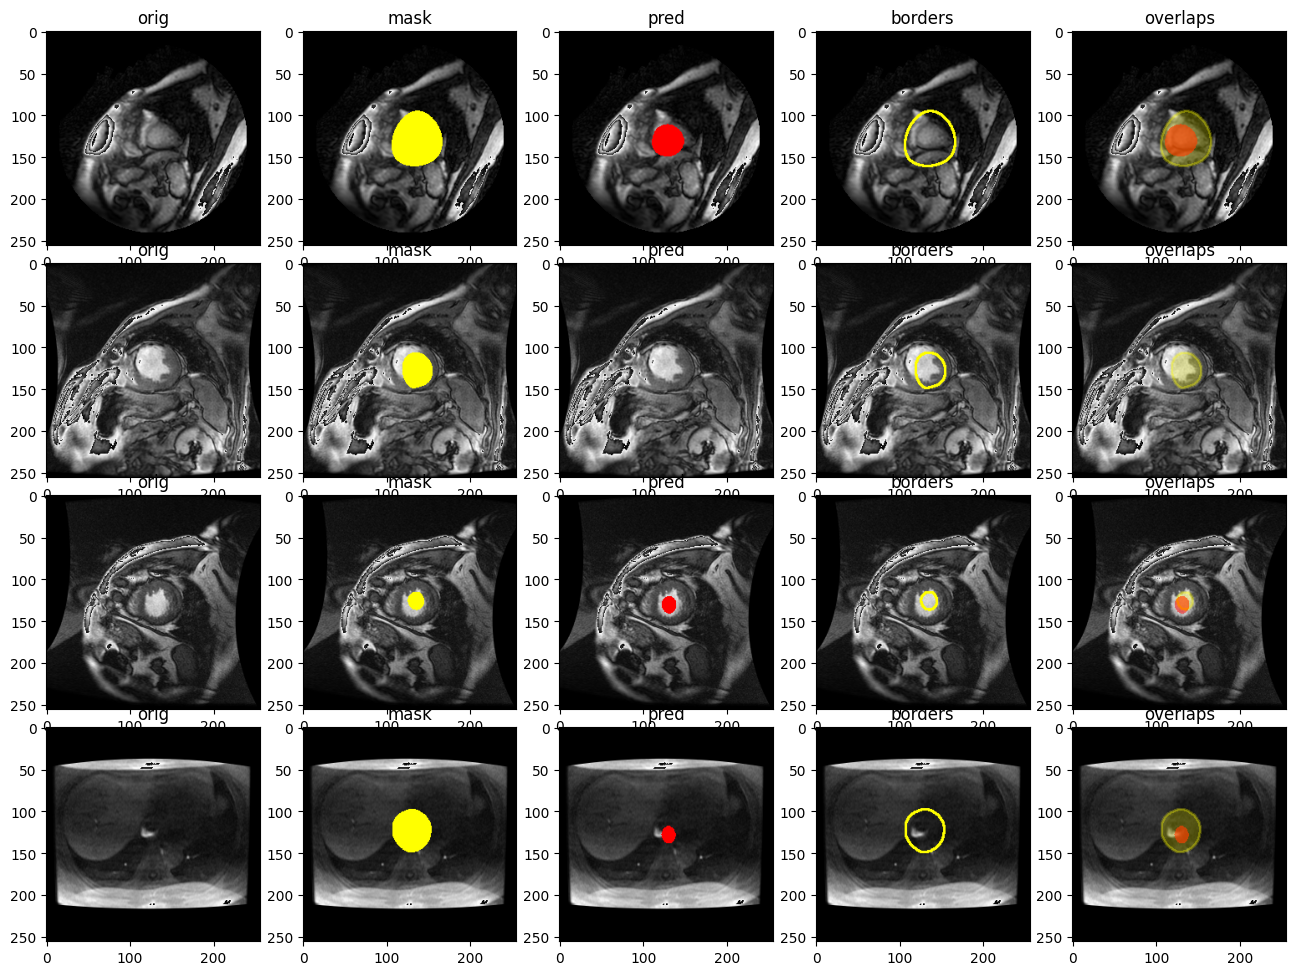

In [ ]:
plot_rows_cols(allimgs,ttls)